## Функциональный APi.
 Достаточно часто, мы хотим строить модели более сложные, чем просто линейный набор слоев. Или хотим добавить какой-то трюк, наподобие прокидывание данных на какой-то из слоев модели (как ResNet архитектура от майкрософт). В таком случае нам на помощь приходит функциональный api от keras. Он позволяет придумывать и реализовывать код как угодно.

## 7.1.1. Введение в функциональный api

In [2]:
import tensorflow.keras as  keras
import tensorflow as tf
from tensorflow.keras import Input, layers 
input_tensor = Input(shape=(32,))
dense = layers.Dense(32, activation='relu')
output_tensor = dense(input_tensor)

Начнем с маленького примера, который описывает как обычную модель можно представить в ввиде api.

In [3]:
from tensorflow.keras.models import Sequential, Model 

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,))) 
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))

input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

model = Model(input_tensor, output_tensor)

In [7]:
!pip install pydot

In [5]:
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes = True)

# SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Единственная часть, которая может показаться немного волшебной в этой точке, - создание экземпляра объекта Model с использованием только входного и выходного тензоров. За кулисами Keras извлекает все слои, участвующие в переходе от input_tensor к output_tensor, объединяя их в графоподобную структуру данных - модель. Конечно, причина этого в том, что output_tensor был получен путем многократного преобразования input_tensor. Если вы попытались построить модель из входных и выходных данных, которые не были связаны, вы получите ValueError:

In [7]:
unrelated_input = Input(shape=(32,))
bad_model = Model(unrelated_input, output_tensor)

ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_3:0", shape=(None, 64), dtype=float32) at layer "input_3". The following previous layers were accessed without issue: []

Ошибка говорит нам о том, что керас не смог достичь output преобразовывая input.

все остальное работает как в стандартной модели, обучение и применение.

In [8]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

import numpy as np
x_train = np.random.random((1000, 64))
y_train = np.random.random((1000, 10)) 

model.fit(x_train, y_train, epochs=10, batch_size=128)

score = model.evaluate(x_train, y_train)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 3s 3ms/sample - loss: 11.7593
Epoch 2/10
1000/1000 [==============================] - 0s 20us/sample - loss: 12.2986
Epoch 3/10
1000/1000 [==============================] - 0s 13us/sample - loss: 13.2593
Epoch 4/10
1000/1000 [==============================] - 0s 14us/sample - loss: 14.4904
Epoch 5/10
1000/1000 [==============================] - 0s 14us/sample - loss: 16.0704
Epoch 6/10
1000/1000 [==============================] - 0s 14us/sample - loss: 17.9941
Epoch 7/10
1000/1000 [==============================] - 0s 14us/sample - loss: 20.2829
Epoch 8/10
1000/1000 [==============================] - 0s 14us/sample - loss: 22.9942
Epoch 9/10
1000/1000 [==============================] - 0s 13us/sample - loss: 26.0421
Epoch 10/10
1000/1000 [==============================] - 0s 98us/sample - loss: 31.5520



### 7.1.2 Модели с несколькими входами

Функциональный API может использоваться для построения моделей с несколькими входами. Как правило, такие модели в какой-то момент объединяют свои различные входные ветви, используя слой, который может объединять несколько тензоров: добавляя их, объединяя их и так далее. Обычно это делается с помощью операции слияния Keras, такой как keras.layers.add, keras.layers.concatenate и так далее.

#### Пример модели с ответом на вопрос
Давайте рассмотрим очень простой пример модели с несколькими входами: модель с ответом на вопрос. Типичная модель ответа на вопрос имеет два входа: вопрос на естественном языке и текстовый фрагмент (такой как новостная статья), предоставляющий информацию, которая будет использоваться для ответа на вопрос. Затем модель должна дать ответ: в простейшей возможной настройке это ответ из одного слова, полученный с помощью softmax по некоторой предопределенной лексике.

Ниже приведен пример того, как вы можете построить такую модель с помощью функционального API. Вы устанавливаете две независимые ветви, кодирующие ввод текста и ввод вопроса в качестве векторов представления; затем объединить эти векторы; и, наконец, добавьте классификатор softmax поверх составных представлений.

#### Функциональная реализация API модели ответа на два вопроса

In [10]:

from tensorflow.keras import Input

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# Ввод текста представляет собой последовательность целых чисел переменной длины.
# Обратите внимание, что вы можете по желанию назвать входы
text_input = Input(shape=(None,), dtype='int32', name='text')
embedded_text = layers.Embedding(text_vocabulary_size,64)(text_input)
# С помощью LSTM переводим текст в последовательность
encoded_text = layers.LSTM(32)(embedded_text)
# Тот же процесс (с разными экземплярами слоя) для вопроса
question_input = Input(shape=(None,),dtype='int32',name='question')
embedded_question = layers.Embedding(question_vocabulary_size,32)(question_input)
encoded_question = layers.LSTM(16)(embedded_question) 
# Соеденяем вопрос и текст
concatenated = layers.concatenate([encoded_text, encoded_question],
                                  axis=-1)
# Добавляем softmax итоговый
answer = layers.Dense(answer_vocabulary_size, activation='softmax')(concatenated)
# Модельс 2мя входами и 1 выходом, поэтому задаем таким образом
model = Model([text_input, question_input], answer)
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',
              metrics=['acc'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
question (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 32)     320000      question[0][0]                   
____________________________________________________________________________________________

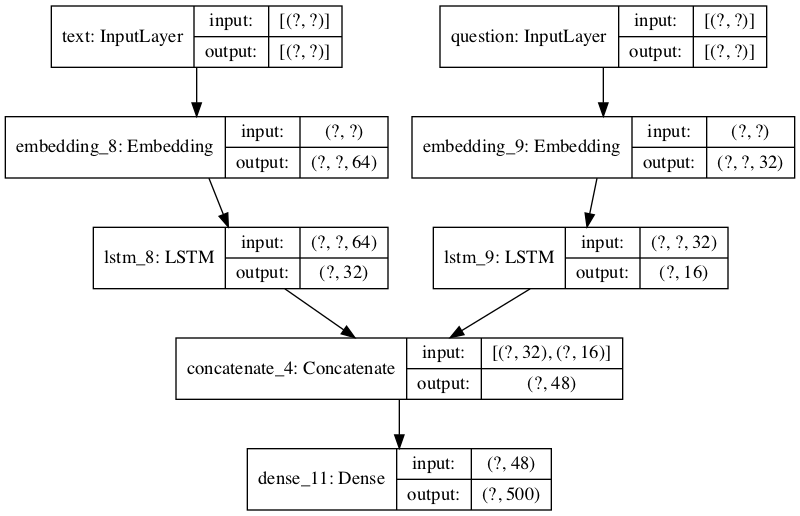

In [11]:
model.summary()


plot_model(model, show_shapes = True)



Теперь, как вы тренируете эту модель с двумя входами? Существует два возможных API: вы можете передать модели список массивов Numpy в качестве входных данных, или вы можете передать ему словарь, который отображает входные имена в массивы Numpy. Естественно, последний вариант доступен только в том случае, если вы даете имена своим входам.

#### Обучение модели с несколькими входами

In [12]:
import numpy as np
num_samples = 1000 
max_length = 100

# создаем данные
text = np.random.randint(1, text_vocabulary_size,size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size,size=(num_samples, max_length)) 
# ответ у нас должен быть one-hot, не число
answers = np.random.randint(answer_vocabulary_size, size=(num_samples))
answers = keras.utils.to_categorical(answers, answer_vocabulary_size)

# Фиттим модеь с листом input
print('-'*10,"First training run with list of NumPy arrays",'-'*60)
model.fit([text, question], answers, epochs=10, batch_size=128)
print()

# тоже самое, но со словарем
print('-'*10,"Second training run with dictionary and named inputs",'-'*60)
model.fit({'text': text, 'question': question}, answers,epochs=10, batch_size=128)

---------- First training run with list of NumPy arrays ------------------------------------------------------------
Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/sample - loss: 6.2145 - acc: 0.0020
Epoch 2/10
1000/1000 [==============================] - 1s 563us/sample - loss: 6.1962 - acc: 0.0520
Epoch 3/10
1000/1000 [==============================] - 1s 572us/sample - loss: 6.1372 - acc: 0.0070
Epoch 4/10
1000/1000 [==============================] - 1s 572us/sample - loss: 6.0485 - acc: 0.0090
Epoch 5/10
1000/1000 [==============================] - 1s 574us/sample - loss: 5.9813 - acc: 0.0120
Epoch 6/10
1000/1000 [==============================] - 1s 566us/sample - loss: 5.9170 - acc: 0.0140
Epoch 7/10
1000/1000 [==============================] - 1s 565us/sample - loss: 5.8497 - acc: 0.0210
Epoch 8/10
1000/1000 [==============================] - 1s 566us/sample - loss: 5.7929 - acc: 0.0230
Epoch 9/10
1000/1000 [==============================] -


### 7.1.3 Модели с несколькими выходами
Вы также можете использовать функциональный API для построения моделей с несколькими выходами (или несколькими головками).

#### Пример - прогноз возраста, пола и дохода от постов в социальных сетях
Простым примером является сеть, которая пытается одновременно предсказать различные свойства данных, например, сеть, которая принимает в качестве входных данных серию сообщений в социальных сетях от одного анонимного человека и пытается предсказать атрибуты этого человека, такие как возраст, пол и уровень дохода.

#### Реализация функциональной API модели прогнозирования с тремя выходами

In [13]:
vocabulary_size = 50000 
num_income_groups = 10 

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size,256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu', padding='same')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
x = layers.Conv1D(256, 5, activation='relu', padding='same')(x) 
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x) 

# Заметим, что выходным лаерам лучше дать имя.
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups,
                                 activation='softmax',name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid',
                                 name='gender')(x)
model = Model(posts_input,[age_prediction, income_prediction, 
                           gender_prediction])

print("Model is ready!")

Model is ready!



Важно отметить, что для обучения такой модели требуется способность задавать разные функции потерь для разных руководителей сети: например, прогнозирование возраста является задачей регрессии, а прогнозирование пола является задачей бинарной классификации, требующей другой процедуры обучения. Но поскольку для градиентного спуска требуется минимизировать дифференцируемый функциона, мы должны объединить эти потери в одно значение, чтобы обучить модель. Самый простой способ объединить разные потери - это сложить их все. В Keras вы можете использовать список или словарь потерь при компиляции, чтобы указать разные объекты для разных выходных данных; полученные значения потерь суммируются в общую потерю, которая минимизируется во время обучения.

#### Опции компиляции модели с несколькими выходами: множественные потери

In [14]:
model.compile(optimizer='rmsprop', loss=['mse', 
                                         'categorical_crossentropy',
                                         'binary_crossentropy'])

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',loss={'age': 'mse',
                                        'income': 'categorical_crossentropy',
                                        'gender': 'binary_crossentropy'})

#### Проблема с несбалансированными потерями

Обратите внимание, что очень несбалансированные вклады в потери приведут к тому, что представления модели будут оптимизированы преимущественно для задачи с наибольшими индивидуальными потерями за счет других задач. Чтобы исправить это, вы можете назначить разные уровни важности значениям потерь в их вкладе в окончательные потери. Это полезно, в частности, если значения потерь используют разные шкалы.

Например, потеря среднего квадрата ошибки (MSE), используемая для задачи регрессии возраста, обычно принимает значение около 3–5, тогда как потеря кросс-энтропии, используемая для задачи классификации по полу, может составлять всего 0,1. В такой ситуации, чтобы уравновесить вклад различных потерь, вы можете назначить вес 10 для потери кроссентропии и вес 0,25 для потери MSE.

#### Решение проблемы несбалансированных потерь

In [15]:
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10.]) 

# Equivalent (possible only if you give names to the output layers)
model.compile(optimizer='rmsprop',
              loss={'age': 'mse','income': 'categorical_crossentropy','gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    163968      embedding_10[0][0]               
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 128)    0           conv1d[0][0]                     
____________________________________________________________________________________________

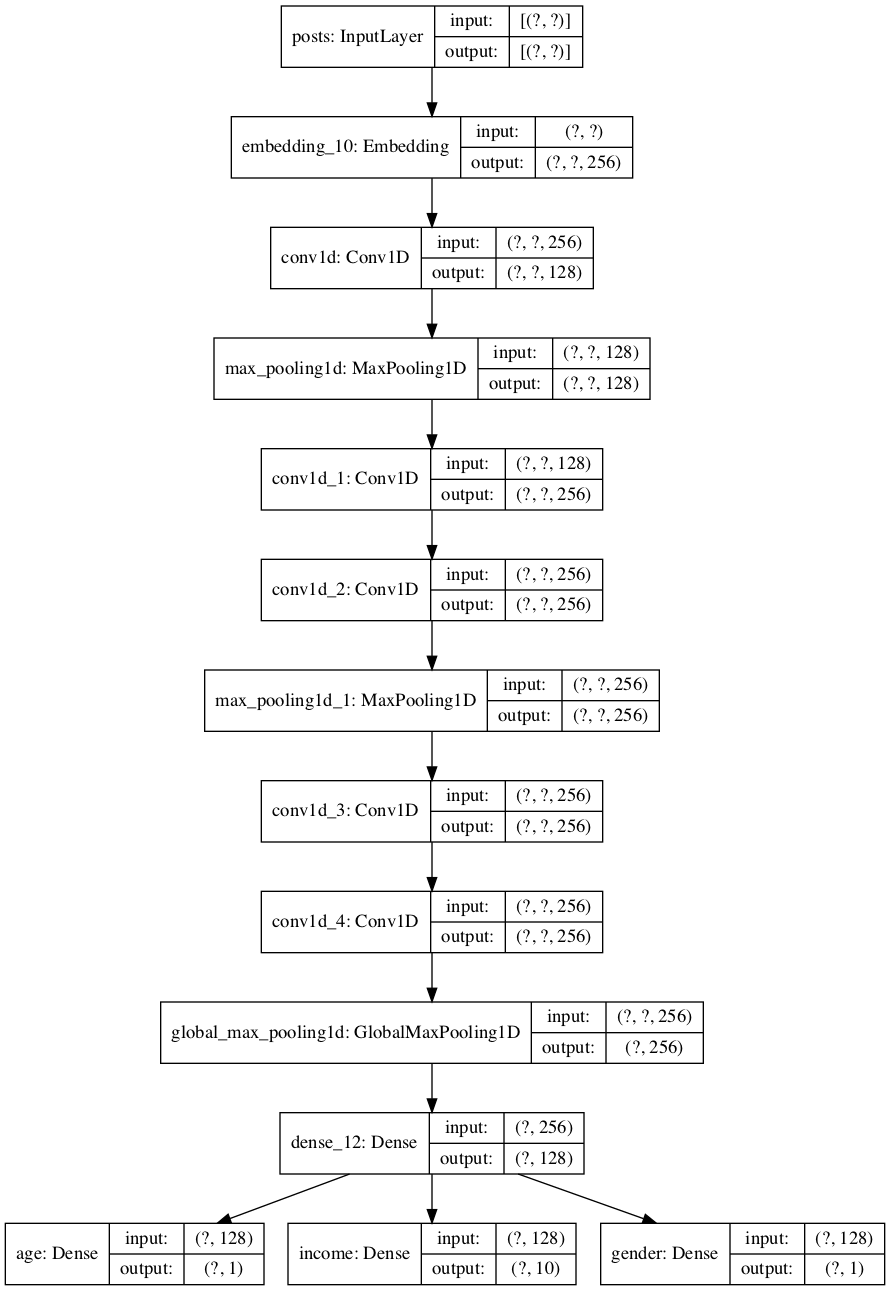

In [17]:
model.summary()



plot_model(model, show_shapes = True)

#### Подача данных в модель с несколькими выходами

Как и в случае моделей с несколькими входами, вы можете передавать данные Numpy в модель для обучения либо через список массивов, либо через словарь массивов.
#### Обучение модели с несколькими выходами

In [18]:
import numpy as np 

TRACE = False

num_samples = 1000 
max_length = 100 

posts = np.random.randint(1, vocabulary_size, size=(num_samples, max_length))
if TRACE:
    print("*** POSTS ***")
    print(posts.shape)
    print(posts[:10])
    print()

age_targets = np.random.randint(0, 100, size=(num_samples,1))
if TRACE:
    print("*** AGE ***")
    print(age_targets.shape)
    print(age_targets[:10])
    print()

income_targets = np.random.randint(1, num_income_groups, size=(num_samples,1))
income_targets = keras.utils.to_categorical(income_targets,num_income_groups)
if TRACE:
    print("*** INCOME ***")
    print(income_targets.shape)
    print(income_targets[:10])
    print()

gender_targets = np.random.randint(0, 2, size=(num_samples,1))
if TRACE:
    print("*** GENDER ***")
    print(gender_targets.shape)
    print(gender_targets[:10])
    print()

print('-'*10, "First training run with NumPy arrays", '-'*60)
# age_targets, income_targets, and gender_targets могут быть numpy массивами
model.fit(posts, [age_targets, income_targets, gender_targets], epochs=10, batch_size=64)

print('-'*10,"Second training run with dictionary and named outputs",'-'*60)
# Тоже самое (и даже предпочительнее), но надо называть свои выходы
model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64)

---------- First training run with NumPy arrays ------------------------------------------------------------
Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/sample - loss: 427.7842 - age_loss: 1637.7454 - income_loss: 3.6515 - gender_loss: 1.0182
Epoch 2/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 222.2981 - age_loss: 839.3823 - income_loss: 2.8819 - gender_loss: 1.1698
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 151.0313 - age_loss: 549.7283 - income_loss: 2.3516 - gender_loss: 0.9875
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 115.3726 - age_loss: 408.8577 - income_loss: 2.3374 - gender_loss: 1.0702
Epoch 5/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 115.4495 - age_loss: 414.6991 - income_loss: 2.3273 - gender_loss: 0.9640
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 65.1390 - age_loss: 204.5022 -

### 7.1.4 Направленные ациклические графы слоев

С помощью функционального API вы можете не только создавать модели с несколькими входами и выходами, но и реализовывать сети со сложной внутренней топологией. Нейронные сети в Керасе могут быть произвольно ориентированными ациклическими графами слоев. Квалификатор acyclic важен: у этих графиков не может быть циклов. Тензор <strong> x </strong> не может стать входом одного из слоев, которые сгенерировали <strong> x </strong>. Разрешены только те циклы обработки (то есть повторяющиеся соединения), которые являются внутренними по отношению к повторяющимся уровням.

Несколько общих компонентов нейронной сети реализованы в виде графиков. Двумя известными из них являются <i> начальные модули </i> и <i> остаточные соединения </i>. Чтобы лучше понять, как функциональный API можно использовать для построения графиков слоев, давайте посмотрим, как вы можете реализовать их оба в Keras.


#### Inception модули

Inception [3] является популярным типом сетевой архитектуры для сверточных нейронных сетей. Он состоит из стека модулей, которые выглядят как небольшие независимые сети, разделенные на несколько параллельных ветвей.

##### Цель 1 × 1 сверток

Свертки 1 × 1 (также называемые точечными свертками) представлены в инсепшион модулях, где они вносят вклад в факторизованное изучение каналов и изучение пространственных объектов.
 

Ну чтож ваша очередь объяснять, что тут в коде происходит :) не только же мне мучаться:)

In [44]:
# Этот пример ожидаем 4д тензор
# Возвращаем тензор, который ожидаем для MNIST
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)


branch_a = layers.Conv2D(128, 1, padding='same',
                         activation='relu', strides=2)(x)


branch_b = layers.Conv2D(128, 1, padding='same', 
                         activation='relu')(x)
branch_b = layers.Conv2D(128, 3, padding='same',
                         activation='relu', strides=2)(branch_b)


branch_c = layers.AveragePooling2D(3,  padding='same', strides=2)(x)
branch_c = layers.Conv2D(128, 3, 
                         padding='same',
                         activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(x) 
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)


output = layers.concatenate([branch_a, branch_b, branch_c, branch_d], 
                            axis=-1)

output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

model_intersept = keras.models.Model(inputs=x, outputs=predictions)
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

x.shape: (None, 28, 28, 1)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 128)  256         images[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  256         images[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 14, 14, 1)    0           images[0][0]                     
____________________________________________________________________________________________

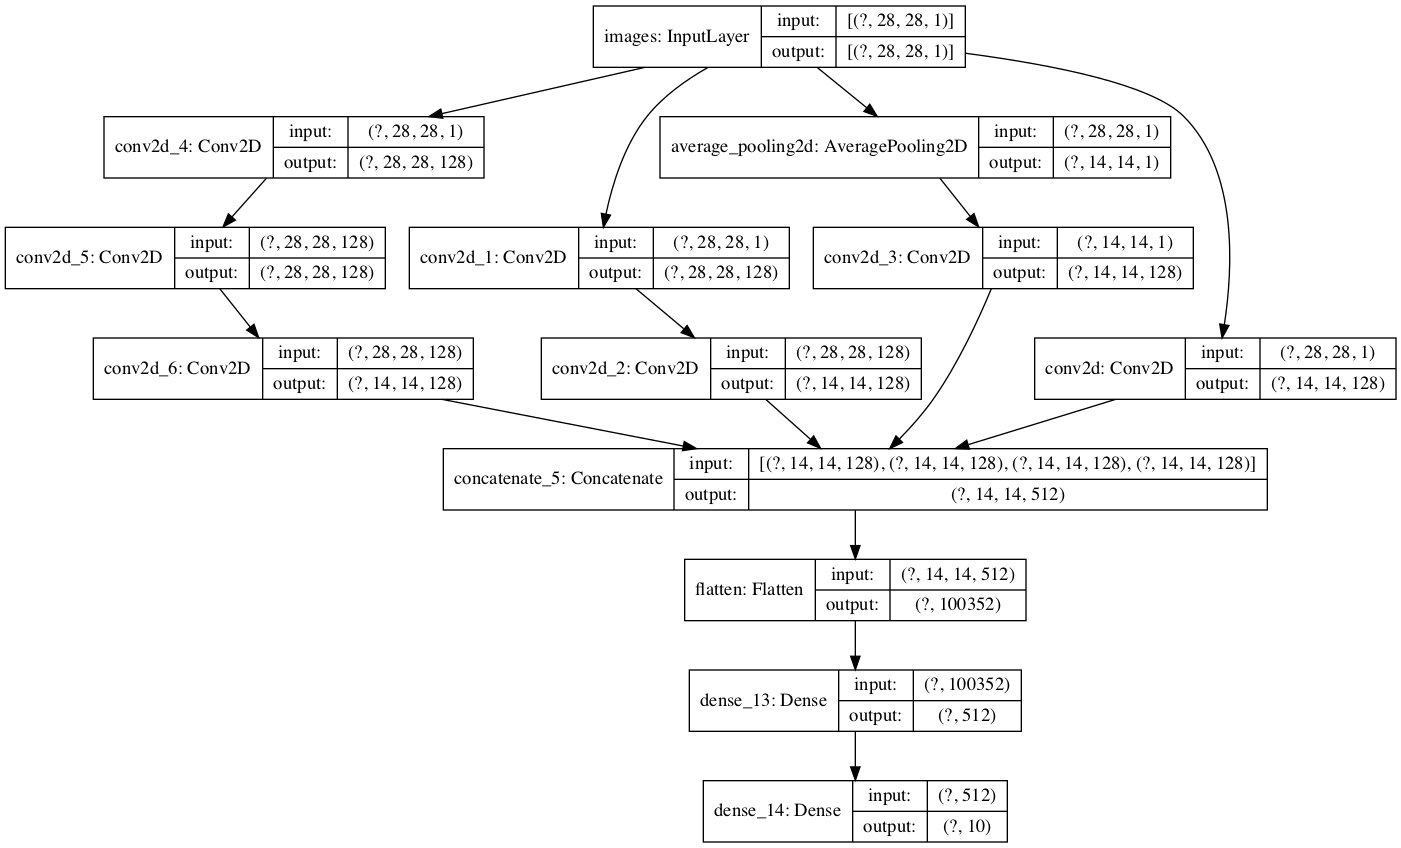

In [25]:
model.summary()



# SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes = True)

#### Обучаем Inception model
В конце концов мы же это делали не раз , не так ли?

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              target_tensors=[targets])


#### Остаточные соединения - ResNET

Остаточные соединения или ResNET являются распространенным графоподобным сетевым компонентом, который встречается во многих сетевых архитектурах после 2015 года, включая Xception. Они были представлены He et al. от Microsoft и решают две общие проблемы с крупномасштабной моделью глубокого обучения: затухающие градиенты и потерю информации при обработке.

Остаточное соединение состоит в том, чтобы сделать выход более раннего уровня доступным в качестве входных данных для более позднего уровня.

###### Реализация ResNET


In [20]:
from keras import layers 
from keras.layers import Input

# Этот пример ожидаем 4д тензор
# Возвращаем тензор, который ожидаем для MNIST
x = Input(shape=(28, 28, 1), dtype='float32', name='images')
print("x.shape:",x.shape)

# Применяем преобразования
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)

# Добавляем х вконец
output = layers.add([y, x])

# Добавляем сверху классификатор
output = layers.Flatten()(output)
output = layers.Dense(512, activation='relu')(output)
predictions = layers.Dense(10, activation='softmax')(output)

x.shape: (?, 28, 28, 1)


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 28, 28, 128)  256         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 128)  256         input_4[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 14, 14, 1)    0           input_4[0][0]                    
____________________________________________________________________________________________

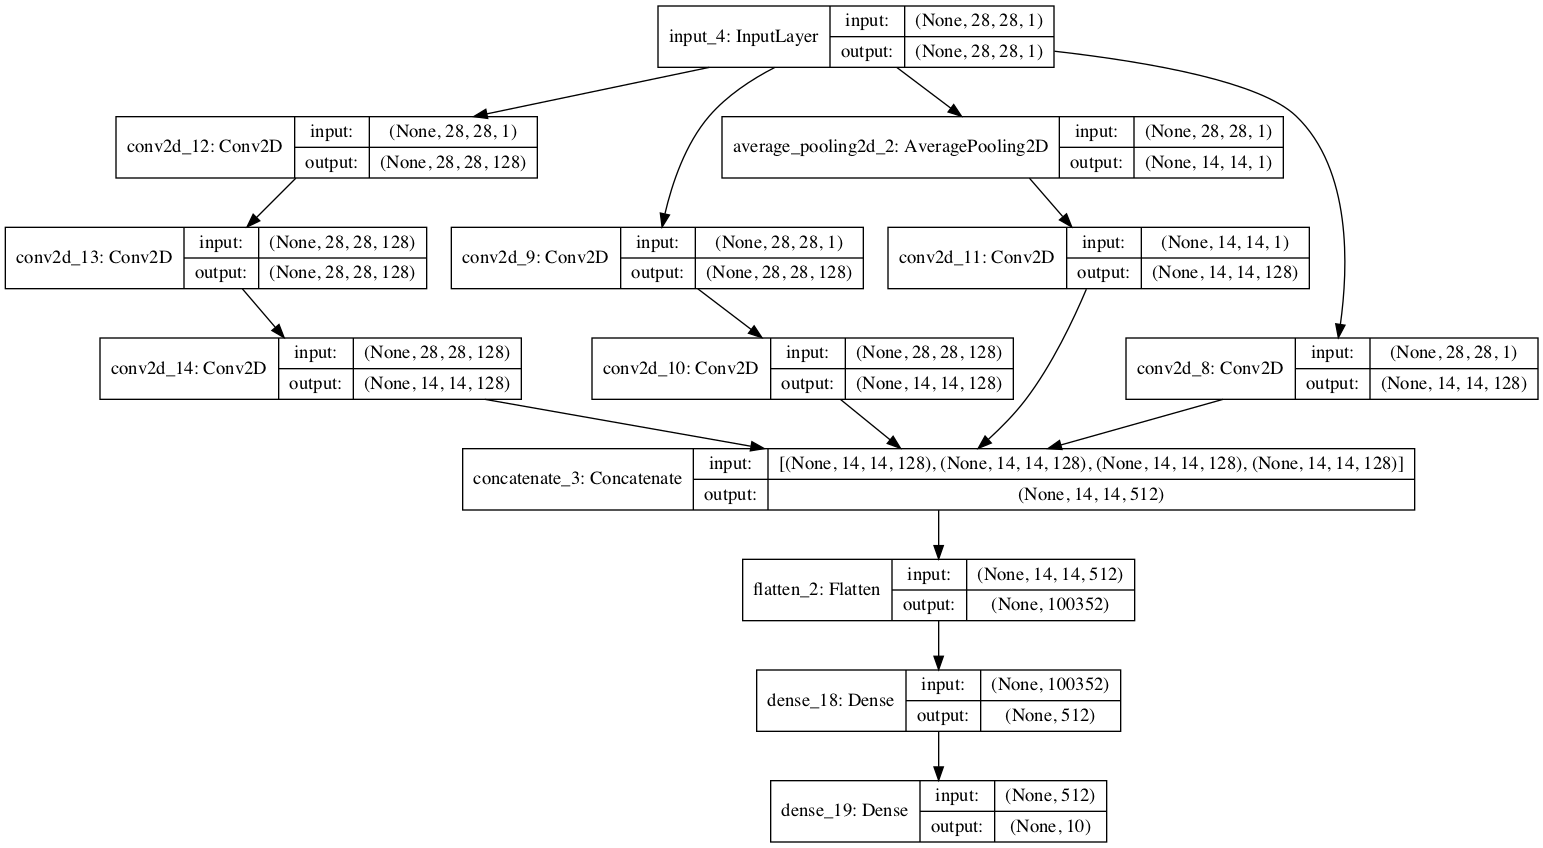

In [22]:
model.summary()

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes = True)

### 7.1.6. Модели как слои

Важно отметить, что в функциональном API модели можно использовать по мере использования слоев - фактически вы можете думать о модели как о «большем слое». Это верно как для классов Sequential, так и для классов Model. Это означает, что вы можете вызвать модель для входного тензора и получить выходной тензор:

    у = модель (х)

Если модель имеет несколько входных тензоров и несколько выходных тензоров, ее следует вызывать со списком тензоров:

    y1, y2 = модель ([x1, x2])

Когда вы вызываете экземпляр модели, вы повторно используете вес модели - точно так же, как и при вызове экземпляра слоя. Вызов экземпляра, будь то экземпляр уровня или экземпляра модели, всегда будет повторно использовать существующие изученные представления экземпляра, что интуитивно понятно.

In [49]:
from tensorflow.keras import applications 


nbr_classes = 10

# Возьмем готовую модель Xception
xception_base = applications.Xception(weights=None,include_top=False)

# входная картинка  250 × 250 RGB.
left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

left_features = xception_base(left_input)
right_features = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_features], axis=-1)

predictions = layers.Dense(nbr_classes, activation='softmax')(merged_features)

#  Собираем нашу модельку
model = Model([left_input, right_input], predictions)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
xception (Model)                multiple             20861480    input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 4096)   0           xception[1][0]             

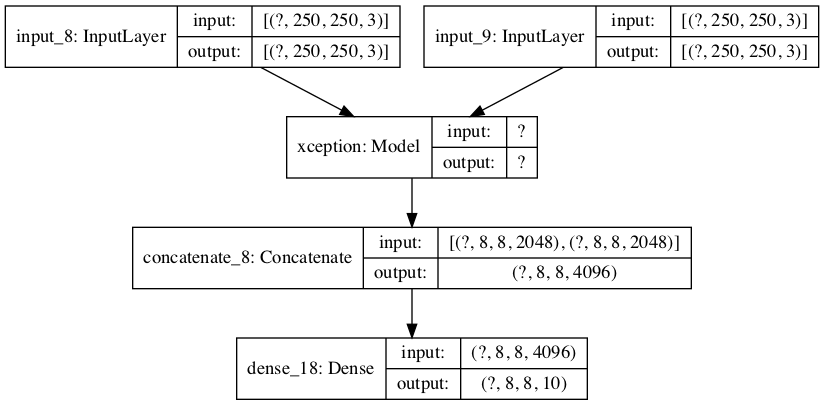

In [50]:
model.summary()




plot_model(model, show_shapes = True)

In [13]:
input_A = layers.Input(shape=(28, 28, 1))
input_B = layers.Input(shape=(36, 36, 1))

branch_A = layers.Conv2D(16,(3,3), activation='relu')(input_A)
branch_A = layers.MaxPool2D()(branch_A)
branch_A = layers.Flatten()(branch_A)

branch_B = layers.Conv2D(32,(3,3), activation='relu')(input_B)
branch_B = layers.MaxPool2D()(branch_B)
branch_B = layers.Conv2D(16,(3,3), activation='relu')(branch_B)
branch_B = layers.MaxPool2D()(branch_B)
branch_B = layers.Flatten()(branch_B)

center = layers.concatenate([branch_A, branch_B], axis = 1)


exit_1 = layers.Dense(20, activation='sigmoid')(center)
exit_1 = layers.Dense(10, activation='softmax')(exit_1)
exit_2 = layers.Dense(20, activation='sigmoid')(center)
exit_2 = layers.Dense(10, activation='sigmoid')(exit_2)


model_my = Model([input_A, input_B], [exit_1, exit_2])

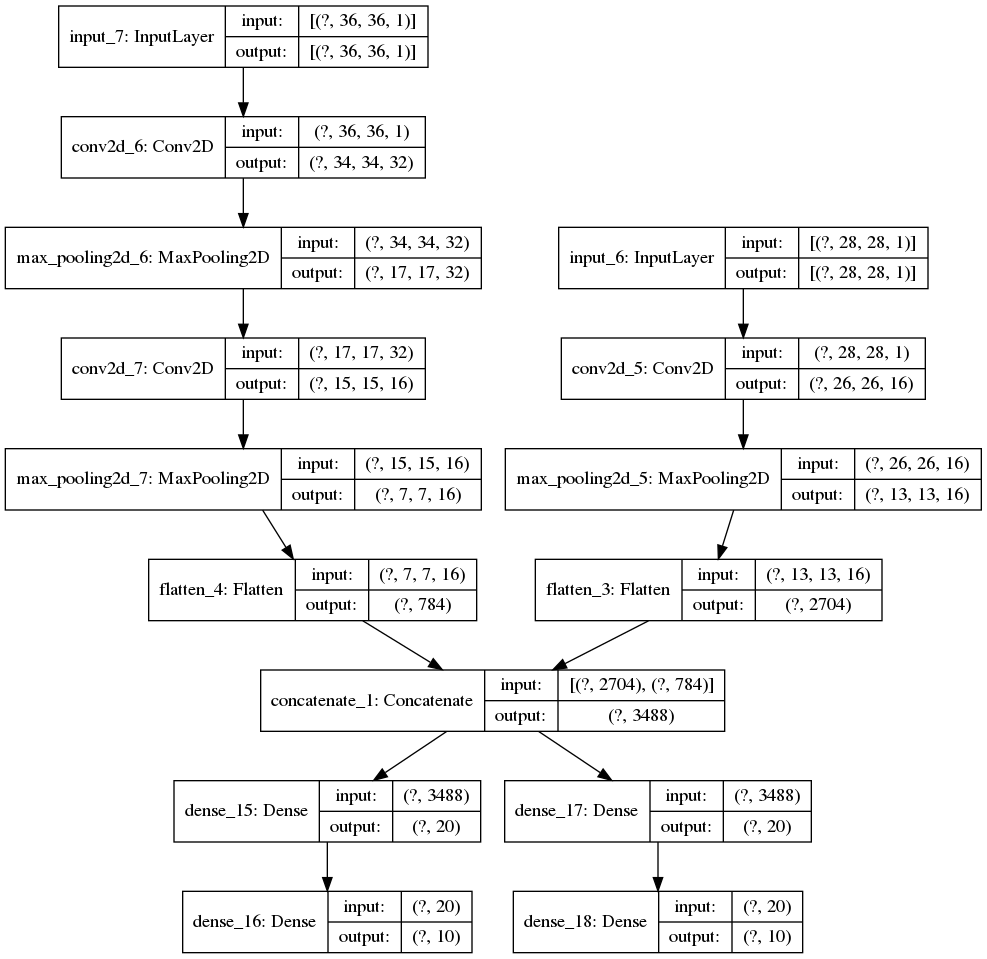

In [14]:
plot_model(model_my,show_shapes=True)

#### Ну и на последок 
 мы же все помним, мы можем писать кастомные callback. Теперь поэтапно смотрим на эту прелесть.
 
 Возьмем уже известную вам модельку с прошлой пары и будем модифицировать наши результаты.

In [15]:
import tensorflow as tf
from tensorflow.keras import Sequential
keras, L = tf.keras, tf.keras.layers

import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline



fashion_mnist = tf.keras.datasets.fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
y_train = keras.utils.to_categorical(y_train).astype(np.float32)
y_test = keras.utils.to_categorical(y_test).astype(np.float32)

# Отнормировали данные к отрезку [0;1]
X_train = X_train/ 255.
X_test = X_test/ 255.
X_train = np.reshape(X_train,[X_train.shape[0],X_train.shape[1],X_train.shape[2],1])
X_test = np.reshape(X_test,[X_test.shape[0],X_test.shape[1],X_test.shape[2],1])

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Теперь давайте соберём свёртоную сеть: 

* Свёртка с ядром $5 \times 5$, same padding и $32$ каналами
* ReLU
* Макспулинг размера $2 \times 2$
* Свёртка с ядром $5 \times 5$ и $16$ каналами  и same padding
* ReLU
* Макспулинг размера $2 \times 2$ с шагом (strides) $2$ по обеим осям 
* Дальше сделайте `Flatten` и сделайте два полносвязных слоя с ReLU и $120$ и $60$ нейронами

In [16]:
model_1 = Sequential( )

# model_1.add(L.InputLayer(input_shape=(28,28)))
model_1.add(L.Conv2D(32,(5,5),padding='same',activation='relu',input_shape=(28,28,1)))
model_1.add(L.MaxPool2D((2,2)))
model_1.add(L.Conv2D(16,(5,5),padding='same',activation='relu'))
model_1.add(L.MaxPool2D((2,2),strides=(2,2)))
model_1.add(L.Flatten())
model_1.add(L.Dense(120, activation='relu'))
model_1.add(L.Dense(60, activation='relu'))

model_1.add(L.Dense(10, activation='softmax'))

model_1.compile("adam", "categorical_crossentropy", metrics=["categorical_accuracy"])

hist = model_1.fit(X_train, y_train, validation_split= 0.2,
                        batch_size=500, epochs=3, verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 3s 61us/sample - loss: 0.8544 - categorical_accuracy: 0.6883 - val_loss: 0.5459 - val_categorical_accuracy: 0.7997
Epoch 2/3
48000/48000 [==============================] - 3s 54us/sample - loss: 0.4960 - categorical_accuracy: 0.8213 - val_loss: 0.4691 - val_categorical_accuracy: 0.8314
Epoch 3/3
48000/48000 [==============================] - 3s 53us/sample - loss: 0.4267 - categorical_accuracy: 0.8494 - val_loss: 0.4251 - val_categorical_accuracy: 0.8481


In [55]:
# Наш класс должен быть отнаследован от керасовского класса

class MyCustomCallback(tf.keras.callbacks.Callback):
    pass

# Но мы можем переписать методы, которые мы отнаследовали
# но для начала посмотреть на них

In [56]:
dir(tf.keras.callbacks.Callback)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'set_model',
 'set_params']

In [62]:
# Теперь нам надо переписать методы которые нам потребуются
# А задача в следующем - посмотреть какой класс проседает по точности на валидационных данных
from sklearn.metrics import precision_score

class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self,X_val,y_val):
        self.X_val = X_val
        self.y_val = y_val
    def on_epoch_end(self,epoch,logs={}):
        prediction = self.model.predict(self.X_val)
        classes_precision = {}
        for i in range(0,10):
            pred_class = np.argmax(prediction,axis=1)==i
            real_class = np.argmax(self.y_val,axis=1)==i
            classes_precision[i] = precision_score(real_class,pred_class) 
        print(classes_precision)

In [63]:
precision_my = MyCustomCallback(X_test,y_test)

In [65]:
hist = model_1.fit(X_train, y_train, validation_split= 0.2,epochs=1,
                       callbacks=[precision_my])

Train on 48000 samples, validate on 12000 samples
48000/48000 [==============================] - 16s 342us/sample - loss: 0.2525 - categorical_accuracy: 0.9063 - val_loss: 0.3007 - val_categorical_accuracy: 0.8988
